## Deep Convolutional GAN(Generative Adversarial Networks)

이 코드는 케라스 Sequential API와 tf.GradientTape 훈련 루프를 사용하여 작성됐습니다.

In [1]:
import os
import glob
import time
import PIL
import imageio

# 딥러닝을 구동하는 데 필요한 케라스 함수 호출
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
print(tf.__version__)

# 필요한 라이브러리 불러옴
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # 이미지를 [-1, 1]로 정규화합니다. 
print(train_images.shape)

BUFFER_SIZE = 60000
BATCH_SIZE = 256


#train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#for x, y in train_dataset:
#    print(x.shape, y.shape)
    
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2.1.0
(60000, 28, 28, 1)


(28, 28)


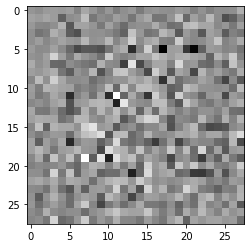

In [2]:
"""
def make_generator:
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
"""

def make_generator(): # Generator 생성자
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Reshape((7,7,256)), # (None, 7, 7, 256)
        
        tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False), # (None, 7, 7, 128)
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False), # (None, 14, 14, 64)
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh') # (None, 28, 28, 1)     
    ])
    
    return model
    
generator = make_generator()
#generator.summary()

noise = tf.random.normal([1,100])
#generated_image = generator.predict(noise)
generated_image = generator(noise, training=False)
print(generated_image[0,:,:,0].shape)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [3]:
def make_discriminator(): # Discriminator 판별자
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    
    return model

discriminator = make_discriminator()
#discriminator.summary()
#decision = discriminator.predict(generated_image)
decision = discriminator(generated_image, training=False)
decision.numpy()

array([[0.00041521]], dtype=float32)

In [4]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss( real_output, fake_output):
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return binary_cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [5]:
''' 체크포인트 저장 '''
checkpoint_dir = './training_checkpoints_tf'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [6]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [7]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [8]:
def generate_and_save_images(model, epoch, test_input):
    # `training`이 False로 맞춰진 것을 주목하세요.
    # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [9]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
            
        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

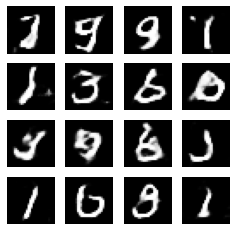

Wall time: 5min 8s


In [10]:
%%time
train(train_dataset, EPOCHS)

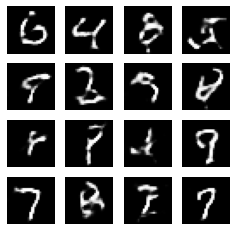

In [11]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])
#noise = tf.random.normal([num_examples_to_generate, noise_dim])
predictions = generator(seed, training=False)
fig = plt.figure(figsize=(4,4))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()

In [19]:
'''Weight들만 저장하기'''
generator.save_weights('./checkpoints_tf/generator.ckpt') # 수동으로 가중치 저장하기
discriminator.save_weights('./checkpoints_tf/discriminator.ckpt')

'''모델 전체 저장하기'''
path = "./saved_generator_model_tf"
if not os.path.isdir(path):
    os.mkdir(path)
generator.save(path) # Generator 모델 저장하기
path = "./saved_discriminator_model_tf"
if not os.path.isdir(path):
    os.mkdir(path)
generator.save(path) # Discriminator 모델 저장하기

INFO:tensorflow:Assets written to: ./saved_generator_model_tf\assets
INFO:tensorflow:Assets written to: ./saved_discriminator_model_tf\assets


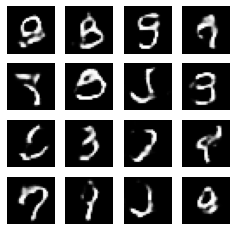

In [20]:
'''모델 전체 불러오기'''
new_generator = tf.keras.models.load_model('./saved_generator_model_tf') # 전체 모델 불러오기

# 모델 구조를 확인합니다
#new_generator.summary()

num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])
#noise = tf.random.normal([num_examples_to_generate, noise_dim])
predictions = new_generator(seed, training=False)
fig = plt.figure(figsize=(4,4))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()

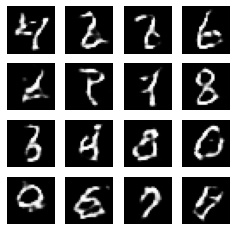

In [22]:
'''모델 weight 불러오기'''
checkpoint_path = "checkpoints_tf/generator.ckpt"
# checkpoint_path = './checkpoints/my_checkpoint'
generator.load_weights(checkpoint_path) # 

num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])
#noise = tf.random.normal([num_examples_to_generate, noise_dim])
predictions = generator(seed, training=False)
fig = plt.figure(figsize=(4,4))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()

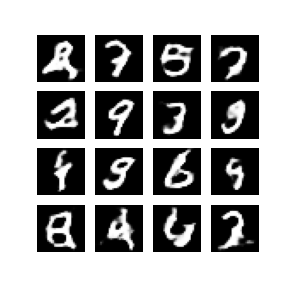

In [11]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

In [12]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

코랩에서 작업하고 있다면, 아래의 코드에서 애니메이션을 다운로드 받을 수 있습니다:

In [101]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)